In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

In [ ]:
# Load the dataset
circles_file = "facebook_combined.txt"
G = nx.read_edgelist(circles_file)

In [ ]:
# 1.2) Compute various characteristics of the network
def compute_network_characteristics(graph):
    prop = {}
    prop['N'] = graph.number_of_nodes() # number of nodes
    prop['M'] = graph.number_of_edges() # number of edges
    # degrees = list(dict(G.degree()).values())
    degrees = [degree for node, degree in graph.degree()] # degree list
    prop['min_degree'] = np.min(degrees) # minimum degree
    prop['max_degree'] = np.max(degrees) # maximum degree
    prop['mean_degree'] = np.mean(degrees) # mean of node degrees
    prop['median_degree'] = np.median(degrees) # median of node degrees
    prop['density'] = nx.density(graph) # density of the graph
    return prop

###################################################################
prop = compute_network_characteristics(graph=G)
print("Number of nodes: {}".format(prop['N']))
print("Number of edges: {}".format(prop['M']))
print("Min. degree: {}".format(prop['min_degree']))
print("Max. degree: {}".format(prop['max_degree']))
print("Mean degree: {}".format(prop['mean_degree']))
print("Median degree: {}".format(prop['median_degree']))
print("Density: {}".format(prop['density']))

Number of nodes: 4039
Number of edges: 88234
Min. degree: 1
Max. degree: 1045
Mean degree: 43.69101262688784
Median degree: 25.0
Density: 0.010819963503439287


## Logistic Regression

In [ ]:
%matplotlib inline
import os
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import *
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [ ]:
def generate_samples(graph, train_set_ratio):
    """
    Graph pre-processing step required to perform supervised link prediction
    Create training and test sets
    """
        
    # --- Step 0: The graph must be connected ---
    if nx.is_connected(G) is not True:
        raise ValueError("The graph contains more than one connected component!")
       
    
    # --- Step 1: Generate positive edge samples for testing set ---
    residual_g = graph.copy()
    test_pos_samples = []
      
    # Shuffle the list of edges
    edges = list(residual_g.edges())
    np.random.shuffle(edges)
    
    # Define number of positive samples desired
    test_set_size = int((1.0 - train_set_ratio) * graph.number_of_edges())
    train_set_size = graph.number_of_edges() - test_set_size
    num_of_pos_test_samples = 0
    
    # Remove random edges from the graph, leaving it connected
    # Fill in the blanks
    for edge in edges:
        
        # Remove the edge
        residual_g.remove_edge(edge[0], edge[1])
        
        # Add the removed edge to the positive sample list if the network is still connected
        if nx.is_connected(residual_g):
            num_of_pos_test_samples += 1
            test_pos_samples.append(edge)
        # Otherwise, re-add the edge to the network
        else: 
            residual_g.add_edge(edge[0], edge[1])
        
        # If we have collected enough number of edges for testing set, we can terminate the loop
        if num_of_pos_test_samples == test_set_size:
            break

    # Check if we have the desired number of positive samples for testing set 
    if num_of_pos_test_samples != test_set_size:
        raise ValueError("Enough positive edge samples could not be found!")

        
    # --- Step 2: Generate positive edge samples for training set ---
    # The remaining edges are simply considered for positive samples of the training set
    train_pos_samples = list(residual_g.edges())
        
        
    # --- Step 3: Generate the negative samples for testing and training sets ---
    # Fill in the blanks
    non_edges = list(nx.non_edges(graph))
    np.random.shuffle(non_edges)
    
    train_neg_samples = non_edges[:train_set_size] 
    test_neg_samples = non_edges[train_set_size:train_set_size + test_set_size]
    
    # --- Step 4: Combine sample lists and create corresponding labels ---
    # For training set
    train_samples = train_pos_samples + train_neg_samples
    train_labels = [1 for _ in train_pos_samples] + [0 for _ in train_neg_samples]
    # For testing set
    test_samples = test_pos_samples + test_neg_samples
    test_labels = [1 for _ in test_pos_samples] + [0 for _ in test_neg_samples]
    
    return residual_g, train_samples, train_labels, test_samples, test_labels

In [ ]:
from tqdm import tqdm

def feature_extractor(graph, samples):
    """
    Creates a feature vector for each edge of the graph contained in samples 
    """
    feature_vector = []
    
    # --- Extract manually diverse features relative to each edge contained in samples --- 
    # Fill in the blanks

    # Degree Centrality measure
    deg_centrality = nx.degree_centrality(graph)
    
    # Betweeness centrality measure
    betweeness_centrality = nx.betweenness_centrality(graph)

    for edge in tqdm(samples):
        source_node, target_node = edge[0], edge[1]

        # Degree Centrality
        source_degree_centrality = deg_centrality[source_node]
        target_degree_centrality = deg_centrality[target_node]
        
        # Betweeness centrality measure 
        diff_bt = betweeness_centrality[target_node] - betweeness_centrality[source_node]

        # Preferential Attachement 
        pref_attach = list(nx.preferential_attachment(graph, [(source_node, target_node)]))[0][2]

        # AdamicAdar
        #aai = list(nx.adamic_adar_index(graph, [(source_node, target_node)]))[0][2]

        # Create edge feature vector with all metric computed above
        feature_vector.append(np.array([source_degree_centrality, target_degree_centrality,
                                        diff_bt, pref_attach]) ) 
        
    return feature_vector

In [ ]:
def prediction(graph, train_features, test_features, train_labels, test_labels):
    """
    Downstream ML task using edge embeddings to classify them 
    """
    
    # --- Build the model and train it ---
    clf = LogisticRegression()
    clf.fit(train_features, train_labels)

    # clf = sm.Logit(train_labels, train_features).fit()
    # print(clf.summary())

    train_preds = clf.predict_proba(train_features)[:, 1]
    test_preds = clf.predict_proba(test_features)[:, 1]

    # --- Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from predictions ---
    fpr, tpr, _ = roc_curve(test_labels, test_preds)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, color='darkred', label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='lightgray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    #plt.show()
    
    return roc_auc, clf

100%|██████████| 35292/35292 [00:00<00:00, 190665.41it/s]


(0.8370967126364126, LogisticRegression())

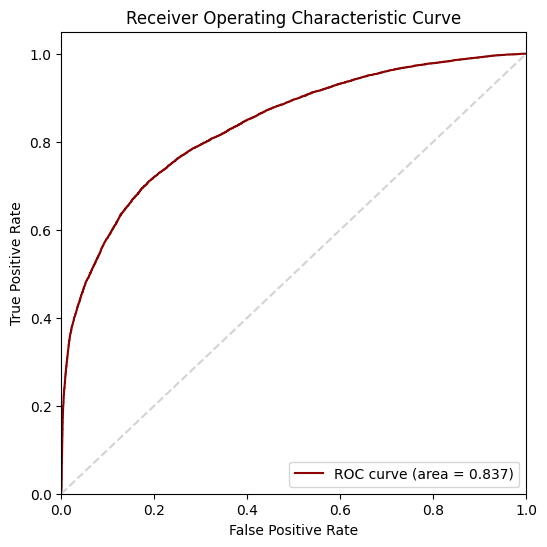

In [ ]:
# --- Construct the training and testing sets ---
residual_g, train_samples, train_labels, test_samples, test_labels = generate_samples(graph=G, train_set_ratio=0.8)

# --- Create feature vector for all edges in training set and test set ---
train_features = feature_extractor(G, train_samples)
test_features = feature_extractor(G, test_samples)

# --- Link prediction ---
prediction(G, train_features, test_features, train_labels, test_labels)

## DeepWalk

In [ ]:
def generate_random_walk(graph, root, L):
    """
    :param graph: networkx graph
    :param root: the node where the random walk starts
    :param L: the length of the walk
    :return walk: list of the nodes visited by the random walk
    """
    walk = [root]
    
    while len(walk) < L:
        current_node = walk[-1]
        candidates = list(nx.neighbors(graph, current_node))
        next = np.random.choice(candidates)
        walk.append(next) 

    return walk

In [ ]:
# Example of a random walk of length 4 from node 30
walk = generate_random_walk(G, '28', 8)
print(walk)

['28', '326', '111', '17', '115', '116', '226', '14']


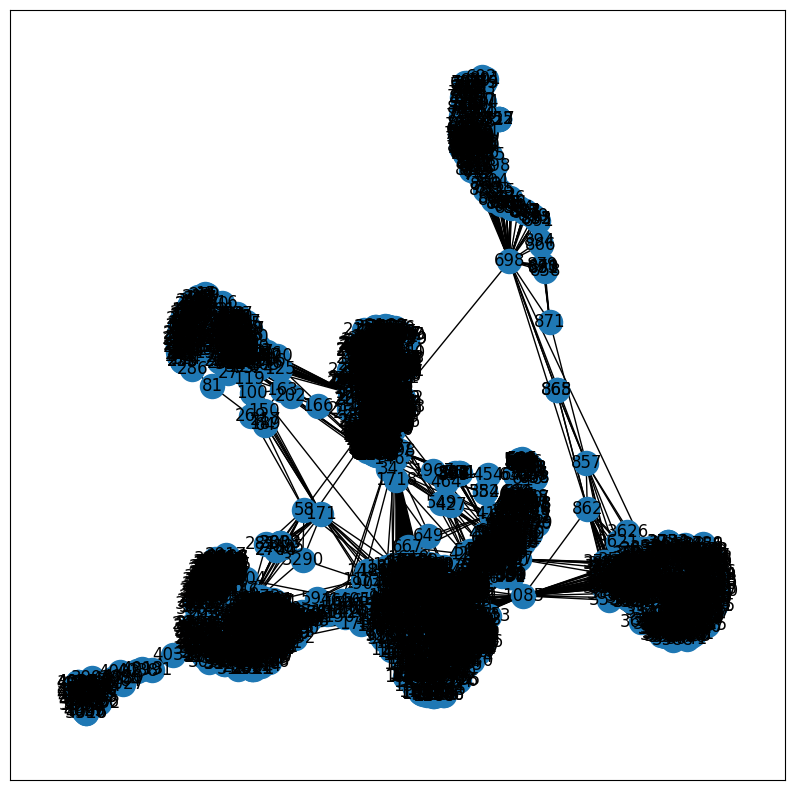

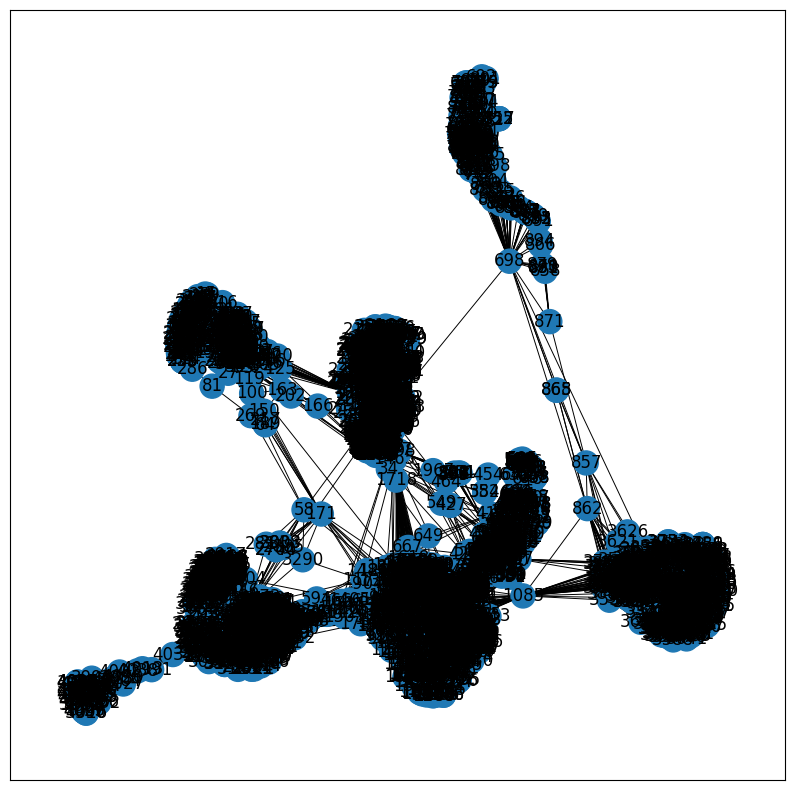

In [ ]:
import matplotlib.pyplot as plt
from helper import *

plt.figure(figsize=(10,10))
layout = nx.fruchterman_reingold_layout(G)
nx.draw_networkx(G, pos=layout, with_labels=True)

def visualize_random_walk(graph, walk):
    walk_edges = []
    for (i, node) in enumerate(walk[:-1]):
        walk_edges.extend(
            [(node, walk[i+1]),
            (walk[i+1], node)]
        )
    edges_color = [
        'r' if edge in walk_edges else 'k' for edge in G.edges 
    ]
    nodes_color = [
        'r' if node in walk else '#1f78b4' for node in G.nodes
    ]
    nodes_size = [
        60 if node in walk else 30 for node in G.nodes
    ]

    plt.figure(figsize=(10,10))
    
    nx.draw_networkx(
        G, with_labels=True, pos=layout, width = 0.7,
        edge_color = edges_color, node_color = nodes_color
        )
    plt.show()

visualize_random_walk(G, walk)

In [ ]:
def deep_walk(graph, N, L):
    '''
    :param graph: networkx graph
    :param N: the number of walks for each node
    :param L: the walk length
    :return walks: the list of walks
    '''
    walks = []

    np.random.seed(4) # fix random seed to obtain same random shuffling when repeating experiment
    nodes = list(G.nodes)

    for _ in range(N):
        np.random.shuffle(nodes) # shuffle the ordering of nodes, it helps speed up the convergence of stochastic gradient descent
        for node in nodes:
            # generate a random walk from the current visited node
            walk = generate_random_walk(graph, node, L)
            walks.append(walk) 
        
    return walks

deep_walk(G, N=3, L=8)

[['2922', '2805', '3121', '2734', '2808', '2734', '1505', '3386'],
 ['869', '774', '752', '847', '706', '731', '713', '772'],
 ['575', '630', '631', '616', '625', '579', '588', '678'],
 ['77', '117', '231', '29', '231', '280', '271', '304'],
 ['1018', '483', '1870', '1763', '1358', '1616', '1320', '1512'],
 ['253', '0', '63', '56', '113', '271', '232', '56'],
 ['1844', '1155', '1677', '580', '1300', '366', '515', '446'],
 ['2668', '3279', '3111', '3145', '3051', '2720', '3076', '3199'],
 ['2614', '2228', '2089', '2082', '2402', '2317', '2644', '1936'],
 ['2006', '2022', '2297', '2365', '2004', '1935', '2636', '1951'],
 ['3237', '2761', '3414', '3286', '2896', '2738', '3232', '3056'],
 ['2056', '2184', '1938', '2069', '2062', '2096', '2243', '2509'],
 ['540', '353', '376', '387', '402', '360', '370', '438'],
 ['162', '149', '116', '0', '296', '99', '68', '0'],
 ['15', '0', '300', '130', '48', '88', '106', '169'],
 ['4035', '3980', '594', '4031', '4002', '3980', '4005', '3998'],
 ['1919'

In [ ]:
def edge_prediction(node2embedding, train_samples, test_samples, train_labels, test_labels, feature_func=None, plot_roc=True):
    
    # --- Construct feature vectors for edges ---
    if feature_func is None:
        feature_func = lambda x,y: abs(x-y)
    
    # Fill in the blanks
    train_features = [feature_func(node2embedding[edge[0]], node2embedding[edge[1]]) for edge in train_samples]
    test_features = [feature_func(node2embedding[edge[0]], node2embedding[edge[1]]) for edge in test_samples]

    circles_file = "facebook_combined.txt"
    G = nx.read_edgelist(circles_file)
    G = nx.relabel_nodes(G, {i: int(i) for i in G.nodes})

    int_train_samples = [[int(j) for j in i] for i in train_samples]
    int_test_samples = [[int(j) for j in i] for i in test_samples]        
    train_features_1 = feature_extractor(G, int_train_samples)
    test_features_1 = feature_extractor(G, int_test_samples)

    train_features = pd.merge(pd.DataFrame(train_features), pd.DataFrame(train_features_1), left_index=True, right_index=True)
    test_features = pd.merge(pd.DataFrame(test_features), pd.DataFrame(test_features_1), left_index=True, right_index=True)

    train_features = np.array(train_features)
    test_features = np.array(test_features)

    # --- Build the model and train it ---
    # Fill in the blanks
    clf = LogisticRegression()
    clf.fit(train_features, train_labels)

    train_preds = clf.predict_proba(train_features)[:, 1]
    test_preds = clf.predict_proba(test_features)[:, 1]

    # --- Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from predictions ---
    # Fill in the blanks
    fpr, tpr, _ = roc_curve(test_labels, test_preds)
    roc_auc = auc(fpr, tpr)

    if not plot_roc:
        return roc_auc
    
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, color='darkred', label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='lightgray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return roc_auc

In [ ]:
residual_g, train_samples, train_labels, test_samples, test_labels = generate_samples(graph=G, train_set_ratio=0.8)

import gensim
import os

embedding_size = 32
results = []
num_of_walks = [100]
walk_length = [10, 20, 50]
window_sizes = [5, 10, 20]

i = 0
for N in num_of_walks:
    for L in walk_length:
        residual_walks = deep_walk(graph=residual_g, N=N, L=L)
        for ws in window_sizes:
            model = Word2Vec(residual_walks, vector_size=embedding_size, sg=1, window=ws, min_count=0, workers=7, hs=1, epochs=1, negative=0)

            roc_auc = edge_prediction(model.wv, train_samples, test_samples, train_labels, test_labels, plot_roc=False)

            # model = gensim.models.Word2Vec.load('/content/drive/MyDrive/mlns/nodel2vec_' + str(i) + '.model')
            model.save('/content/drive/MyDrive/mlns/models/deepwalk_' + str(i) + '.model')
            i += 1
            roc_auc = edge_prediction(model.wv, train_samples, test_samples, train_labels, test_labels, plot_roc=False)
            results.append({
                'num_of_walks': N,
                'walk_length': L,
                'window_size': ws,
                'embedding_method': 'DeepWalk',
                'roc_auc': roc_auc
            }
            )

100%|██████████| 35292/35292 [00:00<00:00, 121523.53it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 35292/35292 [00:00<00:00, 205684.79it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative

In [ ]:
roc_auc_df = pd.DataFrame(results)
roc_auc_df

,num_of_walks,walk_length,window_size,embedding_method,roc_auc
0,100,10,5,DeepWalk,0.991474
1,100,10,10,DeepWalk,0.990721
2,100,10,20,DeepWalk,0.990358
3,100,20,5,DeepWalk,0.989772
4,100,20,10,DeepWalk,0.990214
5,100,20,20,DeepWalk,0.989819
6,100,50,5,DeepWalk,0.988440
7,100,50,10,DeepWalk,0.988855
8,100,50,20,DeepWalk,0.989715


## Node2Vec

In [ ]:
! pip install node2vec

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 38.4 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.1
    Uninstalling networkx-3.1:
      Successfully uninstalled networkx-3.1


In [ ]:
%matplotlib inline
from helper import *
import os
import networkx as nx
from gensim.models import Word2Vec
from node2vec import Node2Vec
from scipy.sparse import *
from scipy.stats.stats import pearsonr
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, auc
from sklearn.preprocessing import LabelEncoder 
import numpy as np
import pandas as pd
import statsmodels.api as sm

<ipython-input-20-62355428004f>:8: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [ ]:
def edge_prediction(node2embedding, train_samples, test_samples, train_labels, test_labels, feature_func=None, plot_roc=True):
    
    # --- Construct feature vectors for edges ---
    if feature_func is None:
        feature_func = lambda x,y: abs(x-y)
    
    # Fill in the blanks
    train_features = [feature_func(node2embedding[edge[0]], node2embedding[edge[1]]) for edge in train_samples]
    test_features = [feature_func(node2embedding[edge[0]], node2embedding[edge[1]]) for edge in test_samples]

    circles_file = "facebook_combined.txt"
    G = nx.read_edgelist(circles_file)
    G = nx.relabel_nodes(G, {i: int(i) for i in G.nodes})

    int_train_samples = [[int(j) for j in i] for i in train_samples]
    int_test_samples = [[int(j) for j in i] for i in test_samples]        
    train_features_1 = feature_extractor(G, int_train_samples)
    test_features_1 = feature_extractor(G, int_test_samples)

    train_features = pd.merge(pd.DataFrame(train_features), pd.DataFrame(train_features_1), left_index=True, right_index=True)
    test_features = pd.merge(pd.DataFrame(test_features), pd.DataFrame(test_features_1), left_index=True, right_index=True)

    train_features = np.array(train_features)
    test_features = np.array(test_features)

    # --- Build the model and train it ---
    # Fill in the blanks
    clf = LogisticRegression()
    clf.fit(train_features, train_labels)

    train_preds = clf.predict_proba(train_features)[:, 1]
    test_preds = clf.predict_proba(test_features)[:, 1]

    # --- Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from predictions ---
    # Fill in the blanks
    fpr, tpr, _ = roc_curve(test_labels, test_preds)
    roc_auc = auc(fpr, tpr)

    if not plot_roc:
        return roc_auc
    
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, color='darkred', label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='lightgray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return roc_auc

In [ ]:
# Load the dataset
circles_file = "facebook_combined.txt"
G = nx.read_edgelist(circles_file)

In [ ]:
#residual_g, train_samples, train_labels, test_samples, test_labels = generate_samples(graph=G, train_set_ratio=0.8)

import gensim
import os

results = []
num_of_walks = [100, 300]
walk_length = [10, 20, 50]
window_sizes = [5, 10, 20]

i = 0
for N in num_of_walks:
    for L in walk_length:
        for ws in window_sizes:
            # Learn representations of nodes
            node2vec = Node2Vec(residual_g, dimensions=32, walk_length=L, num_walks=N, workers=7, p=1, q=1)
            # Embed nodes
            model = node2vec.fit(window=ws, min_count=1, batch_words=4)
            # model = gensim.models.Word2Vec.load('/content/drive/MyDrive/mlns/nodel2vec_' + str(i) + '.model')
            model.save('/content/drive/MyDrive/mlns/models/nodel2vec_' + str(i) + '.model')
            i += 1
            roc_auc = edge_prediction(model.wv, train_samples, test_samples, train_labels, test_labels, plot_roc=False)
            results.append({
                'num_of_walks': N,
                'walk_length': L,
                'window_size': ws,
                'embedding_method': 'Node2Vec',
                'roc_auc': roc_auc
            }
            )

Computing transition probabilities:   0%|          | 0/4039 [00:00<?, ?it/s]

100%|██████████| 35292/35292 [00:00<00:00, 224126.02it/s]


Computing transition probabilities:   0%|          | 0/4039 [00:00<?, ?it/s]

100%|██████████| 35292/35292 [00:00<00:00, 118825.16it/s]


Computing transition probabilities:   0%|          | 0/4039 [00:00<?, ?it/s]

100%|██████████| 35292/35292 [00:00<00:00, 202836.73it/s]


Computing transition probabilities:   0%|          | 0/4039 [00:00<?, ?it/s]

100%|██████████| 35292/35292 [00:00<00:00, 195911.68it/s]


Computing transition probabilities:   0%|          | 0/4039 [00:00<?, ?it/s]

100%|██████████| 35292/35292 [00:00<00:00, 112217.37it/s]


Computing transition probabilities:   0%|          | 0/4039 [00:00<?, ?it/s]

100%|██████████| 35292/35292 [00:00<00:00, 119101.08it/s]


Computing transition probabilities:   0%|          | 0/4039 [00:00<?, ?it/s]

100%|██████████| 35292/35292 [00:00<00:00, 183314.75it/s]


Computing transition probabilities:   0%|          | 0/4039 [00:00<?, ?it/s]

100%|██████████| 35292/35292 [00:00<00:00, 124427.46it/s]


Computing transition probabilities:   0%|          | 0/4039 [00:00<?, ?it/s]

100%|██████████| 35292/35292 [00:00<00:00, 111717.52it/s]


Computing transition probabilities:   0%|          | 0/4039 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
roc_auc_df = pd.DataFrame(results)
roc_auc_df

,num_of_walks,walk_length,window_size,embedding_method,roc_auc
0,100,10,5,Node2Vec,0.992068
1,100,10,10,Node2Vec,0.993209
2,100,10,20,Node2Vec,0.993334
3,100,20,5,Node2Vec,0.992940
4,100,20,10,Node2Vec,0.993573
5,100,20,20,Node2Vec,0.993863
6,100,50,5,Node2Vec,0.993115
7,100,50,10,Node2Vec,0.992582
8,100,50,20,Node2Vec,0.993687


## GAT

In [ ]:
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/benedekrozemberczki/pytorch_geometric_temporal.git
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.6/107.6 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 68.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 616.2/616.2 kB 39.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.5.3, but you have pandas 1.3.5 which is incompatible.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import torch
from torch_geometric.loader import DataLoader 
import torch_geometric.transforms as T
import random
import pandas as pd
import numpy as np

In [ ]:
df_links = pd.read_csv("facebook_combined.txt", header = None, sep = ' ')

In [ ]:
# Perform merge to obtain the edges of the mapped ID
df_nodes_out = pd.DataFrame(np.array(df_links[0]), columns = ['ID'])
nodes_out = torch.from_numpy(df_nodes_out['ID'].values)

df_nodes_in = pd.DataFrame(np.array(df_links[1]), columns = ['ID'])
nodes_in = torch.from_numpy(df_nodes_in['ID'].values)

# With this, we are ready to construct our `edge_index` in COO format
# following PyG semantics:
edge_index = torch.stack([nodes_out, nodes_in], dim=0)

print()
print("Final edge indices")
print("=================================================")
print(edge_index)


Final edge indices
tensor([[   0,    0,    0,  ..., 4027, 4027, 4031],
        [   1,    2,    3,  ..., 4032, 4038, 4038]])


In [ ]:
import networkx as nx
circles_file = "facebook_combined.txt"
G = nx.read_edgelist(circles_file)

G.number_of_nodes()

4039

In [ ]:
from torch_geometric.data import Dataset, Data
data = Data(edge_index=edge_index)
len_edge = data.num_edges
class MyDataset(Dataset):
    def __init__(self, edge_index, num_nodes, transform=None, pre_transform=None):
        self.edge_index = edge_index
        self.num_nodes = num_nodes
        super(MyDataset, self).__init__(None, transform, pre_transform)

    def len(self):
        return 50

    def get(self, idx):
        edge_lists = torch.tensor(self.edge_index[0: 2, range(0, int(len_edge / 50 * (idx + 1)))], dtype=torch.long).clone().detach()
        num_nodes = self.num_nodes
        return Data(edge_index=edge_lists, num_nodes = num_nodes)

In [ ]:
dataset = MyDataset(edge_index=edge_index, num_nodes = 4039)
dataset

MyDataset(50)

In [ ]:
from sklearn.model_selection import train_test_split
train_dataset, test_dataset = train_test_split(dataset, test_size = 0.2, shuffle = False)
print(dataset[0])

<ipython-input-7-8196fc0789f0>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_lists = torch.tensor(self.edge_index[0: 2, range(0, int(len_edge / 50 * (idx + 1)))], dtype=torch.long).clone().detach()


Data(edge_index=[2, 1764], num_nodes=4039)


In [ ]:
print(len(train_dataset))
print(len(test_dataset))

40
10


In [ ]:
# For this, we first split the set of edges into
# training (80%), validation (10%), and testing edges (10%).
# Across the training edges, we use 70% of edges for message passing,
# and 30% of edges for supervision.
# We further want to generate fixed negative edges for evaluation with a ratio of 2:1.
# Negative edges during training will be generated on-the-fly.
# We can leverage the `RandomLinkSplit()` transform for this from PyG:
transform = T.RandomLinkSplit(is_undirected=True,
    num_val = 0.1,
    num_test = 0.1,
    neg_sampling_ratio = 2,
    add_negative_train_samples = True
)

train_data, val_data, test_data = transform(data)
print("Training data:")
print("==============")
print(train_data)
print()
print("Validation data:")
print("================")
print(val_data)

/usr/local/lib/python3.9/dist-packages/torch_geometric/data/storage.py:304: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


Training data:
Data(edge_index=[2, 141176], edge_label=[211764], edge_label_index=[2, 211764])

Validation data:
Data(edge_index=[2, 141176], edge_label=[26469], edge_label_index=[2, 26469])


In [ ]:
def normalizeAdjacency(W):
    # Check that the matrix is square
    assert W.shape[0] == W.shape[1]
    # Compute the degree vector
    d = torch.sum(W, axis = 1)
    # Invert the square root of the degree
    d = 1/torch.sqrt(d)
    # And build the square root inverse degree matrix
    D = torch.diag(d)
    # Return the Normalized Adjacency
    return D @ W @ D 

#Snapshot to adjacency matrix
def snap_to_adjmat(snapshot):
    x = torch.FloatTensor(torch.zeros(snapshot.num_nodes, snapshot.num_nodes))
    for j in range(snapshot.edge_index.size()[1]):
        v1 = snapshot.edge_index[:,j][0].item()
        v2 = snapshot.edge_index[:,j][1].item()
        x[v1][v2] = 1.0
    for i in range(snapshot.num_nodes):
        x[i][i] = 1.0

    #symetric normalisation(High time complexity)
    #x = normalizeAdjacency(x);
    return x

In [ ]:
# Similarity index
def similarity(vec1, vec2):
    return torch.dot(vec1, vec2)

In [ ]:
from typing import Optional, Tuple

import torch
from torch import Tensor
from torch.nn import GRU
from torch_geometric.typing import Adj, OptTensor
from torch_sparse import SparseTensor
from torch_geometric.nn.inits import glorot
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.conv.gcn_conv import gcn_norm

class GCNConv_Fixed_W(MessagePassing):
    _cached_edge_index: Optional[Tuple[Tensor, Tensor]]
    _cached_adj_t: Optional[SparseTensor]

    def __init__(self, in_channels: int, out_channels: int,
                 improved: bool = False, cached: bool = False,
                 add_self_loops: bool = True, normalize: bool = True,
                **kwargs):

        kwargs.setdefault('aggr', 'add')
        super(GCNConv_Fixed_W, self).__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.improved = improved
        self.cached = cached
        self.add_self_loops = add_self_loops
        self.normalize = normalize

        self._cached_edge_index = None
        self._cached_adj_t = None

        self.reset_parameters()

    def reset_parameters(self):
        self._cached_edge_index = None
        self._cached_adj_t = None


    def forward(self, W: torch.FloatTensor, x: Tensor, edge_index: Adj,
                edge_weight: OptTensor = None) -> Tensor:

        if self.normalize:
            cache = self._cached_edge_index
            if cache is None:
                edge_index, edge_weight = gcn_norm(  # yapf: disable
                    edge_index, edge_weight, x.size(self.node_dim),
                    self.improved, self.add_self_loops, dtype = float)

        x = torch.matmul(x, W)

        # propagate_type: (x: Tensor, edge_weight: OptTensor)
        out = self.propagate(edge_index, x=x, edge_weight=edge_weight,
                             size=None)

        return out


    def message(self, x_j: Tensor, edge_weight: OptTensor) -> Tensor:
        return x_j if edge_weight is None else edge_weight.view(-1, 1) * x_j

class attention(torch.nn.Module):
  def __init__(self):
    super(attention, self).__init__()

  def forward(self, X: Tensor, edge_index: Adj) -> Tensor:
    embed_prod = torch.zeros(X.shape[0], X.shape[0])
    for i in range(X.shape[0]):
      embed_prod[i] = torch.exp(torch.sum(torch.mul(X[i], X), axis = 1))
    
    alpha = torch.zeros(X.shape[0])
    edges = edge_index.T
    for edge in edges:
      alpha[edge[0]] += embed_prod[edge[0]][edge[1]]
    
    for i in range(X.shape[0]):
      alpha[i] += embed_prod[i][i]
    
    for i in range(X.shape[0]):
      embed_prod[i] /= alpha[i]
#    Y = X.detach()
    Y = torch.zeros(X.shape[0], X.shape[1]).to(device)
    for i in range(X.shape[0]):
      Y[i] = torch.mul(embed_prod[i][i], X[i])
    
    for edge in edges:
      Y[edge[0]] += torch.mul(embed_prod[edge[0]][edge[1]], X[edge[1]])
    return X
    
class EvolveGCNO_(torch.nn.Module):
    def __init__(
        self,
        in_channels: int,
        improved: bool = False,
        cached: bool = False,
        normalize: bool = True,
        add_self_loops: bool = True,
    ):
        super(EvolveGCNO_, self).__init__()

        self.in_channels = in_channels
        self.improved = improved
        self.cached = cached
        self.normalize = normalize
        self.add_self_loops = add_self_loops
        self.weight = None
        self.initial_weight = torch.nn.Parameter(torch.Tensor(in_channels, in_channels))
        self._create_layers()
        self.reset_parameters()
    
    def reset_parameters(self):
        glorot(self.initial_weight)


    def _create_layers(self):

        self.recurrent_layer = GRU(
            input_size=self.in_channels, hidden_size=self.in_channels, num_layers=1
        )
        for param in self.recurrent_layer.parameters():
            param.requires_grad = True
            param.retain_grad()

        self.conv_layer = GCNConv_Fixed_W(
            in_channels=self.in_channels,
            out_channels=self.in_channels,
            improved=self.improved,
            cached=self.cached,
            normalize=self.normalize,
            add_self_loops=self.add_self_loops
        )

        self.attention_layer = attention()

    def forward(
        self,
        X: torch.FloatTensor,
        edge_index: torch.LongTensor,
        edge_weight: torch.FloatTensor = None,
    ) -> torch.FloatTensor:

        if self.weight is None:
            self.weight = self.initial_weight.data
        W = self.weight[None, :, :]
        _, W = self.recurrent_layer(W, W)
        X = self.conv_layer(W.squeeze(dim=0), X, edge_index, edge_weight)
        X = self.attention_layer(X, edge_index)
        return X

In [ ]:
num_nodes = dataset[0].num_nodes

<ipython-input-7-8196fc0789f0>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_lists = torch.tensor(self.edge_index[0: 2, range(0, int(len_edge / 50 * (idx + 1)))], dtype=torch.long).clone().detach()


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import EvolveGCNO
from torch_geometric.nn import GATConv
import torch.nn as nn

class EvolveGAT(torch.nn.Module):
    def __init__(self, in_channels, emb_dim):
        super(EvolveGAT, self).__init__()
        self.linear = torch.nn.Linear(num_nodes, emb_dim)
        self.relu = nn.ReLU()
        self.recurrent = EvolveGCNO_(in_channels, add_self_loops=False, normalize=False)
        
    #forward propogation
    def encode(self, x, edge_index, edge_weight):
        h = self.linear(x)
        h = F.relu(h)
        h = self.recurrent(h, edge_index, edge_weight)
        return h

    #for edge classification (per edge)
    def decode(self, z, pos_edge_index, neg_edge_index): # only pos and neg edges
        edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=-1) # concatenate pos and neg edges
        logits = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1)  # dot product 
        return logits

    #for all edge 
    def decode_all(self, z): 
        prob_adj = z @ z.t() # get adj NxN
        return (prob_adj > 0).nonzero(as_tuple=False).t() # get predicted edge_list 

In [ ]:
from torch_geometric.utils import train_test_split_edges
from torch_geometric.utils import negative_sampling
import torch.nn.functional as F

def get_link_labels(pos_edge_index, neg_edge_index):
    # returns a tensor:
    # [1,1,1,1,...,0,0,0,0,0,..] with the number of ones is equel to the lenght of pos_edge_index
    # and the number of zeros is equal to the length of neg_edge_index
    E = pos_edge_index.size(1) + neg_edge_index.size(1)
    link_labels = torch.zeros(E, dtype=torch.float, device=device)
    link_labels[:pos_edge_index.size(1)] = 1.
    return link_labels

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device used: {device}')

Device used: cuda


In [ ]:
neg_edge_index = negative_sampling(
    edge_index = dataset[0].edge_index, #positive edges
    num_nodes = dataset[0].num_nodes, # number of nodes
    num_neg_samples = dataset[0].edge_index.size(1)
) 
pos_edge_index = dataset[0].edge_index

In [ ]:
#Check fns.
print(pos_edge_index.size())
print(neg_edge_index.size())
E = pos_edge_index.size(1) + neg_edge_index.size(1)
link_labels = torch.zeros(E, dtype=torch.float, device=device)
link_labels[:pos_edge_index.size(1)] = 1.
print(link_labels)

torch.Size([2, 1764])
torch.Size([2, 1764])
tensor([1., 1., 1.,  ..., 0., 0., 0.])


In [ ]:
#Hyperparameters
emb_dim = 30
model = EvolveGAT(in_channels = emb_dim, emb_dim = emb_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

In [ ]:
from tqdm import tqdm

def train():
    for epoch in tqdm(range(20)):
        cost = 0
        for time, snapshot in enumerate(train_dataset):
            adj_mat = snap_to_adjmat(snapshot).to(device)
            next_snap = dataset[time]

            neg_edge_index = negative_sampling(
                edge_index = next_snap.edge_index, #positive edges
                num_nodes = next_snap.num_nodes, # number of nodes
                num_neg_samples = next_snap.edge_index.size(1)
                ) # number of neg_sample equal to number of pos_edges

            optimizer.zero_grad()

            y_hat = model.encode(adj_mat, snapshot.edge_index.to(device), edge_weight = None)
            link_logits = model.decode(y_hat, next_snap.edge_index, neg_edge_index) # decode
            link_labels = get_link_labels(next_snap.edge_index, neg_edge_index)
            
            loss = F.binary_cross_entropy_with_logits(link_logits, link_labels)
            loss.backward()
            cost += loss.item()
            optimizer.step()
        cost /= len(train_dataset) 
        print(f'Time: {epoch}', f'Cost: {cost}')
    return cost
#torch.autograd.set_detect_anomaly(True)
train()

  0%|          | 0/20 [00:00<?, ?it/s]<ipython-input-7-8196fc0789f0>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_lists = torch.tensor(self.edge_index[0: 2, range(0, int(len_edge / 50 * (idx + 1)))], dtype=torch.long).clone().detach()


In [ ]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

In [ ]:
print('AUC Score')
@torch.no_grad()
def test():
    perf = []
    for time, snapshot in enumerate(test_dataset[:-1]):
        adj_mat = snap_to_adjmat(snapshot).to(device)
        next_snap = dataset[time+40]
        pos_edge_index = next_snap.edge_index
        neg_edge_index = negative_sampling(
            edge_index = next_snap.edge_index, #positive edges
            num_nodes = next_snap.num_nodes, # number of nodes
            num_neg_samples = next_snap.edge_index.size(1)
            ) # number of neg_sample equal to number of pos_edges


        y_hat = model.encode(adj_mat, snapshot.edge_index.to(device), edge_weight = None)
        link_logits = model.decode(y_hat, next_snap.edge_index, neg_edge_index) # decode
        link_probs = link_logits.sigmoid() # apply sigmoid
        link_labels = get_link_labels(next_snap.edge_index, neg_edge_index)
        auc = roc_auc_score(link_labels.cpu(), link_probs.cpu())
        print(f'Time: {time} -> AUC: {auc}')
        perf.append(roc_auc_score(link_labels.cpu(), link_probs.cpu())) #compute roc_auc score 
    return perf
perf = test()

## Visualization

In [36]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

In [37]:
# Load the dataset
circles_file = "facebook_combined.txt"
G = nx.read_edgelist(circles_file)

In [ ]:
# --- Construct the training and testing sets ---
residual_g, train_samples, train_labels, test_samples, test_labels = generate_samples(graph=G, train_set_ratio=0.8)


In [38]:
def get_roc_log(graph, train_features, test_features, train_labels, test_labels):
    """
    Downstream ML task using edge embeddings to classify them 
    """
    
    # --- Build the model and train it ---
    clf = LogisticRegression()
    clf.fit(train_features, train_labels)

    # clf = sm.Logit(train_labels, train_features).fit()
    # print(clf.summary())

    train_preds = clf.predict_proba(train_features)[:, 1]
    test_preds = clf.predict_proba(test_features)[:, 1]

    # --- Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from predictions ---
    fpr, tpr, _ = roc_curve(test_labels, test_preds)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, color='darkred', label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='lightgray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    #plt.show()
    
    return fpr, tpr, roc_auc

In [50]:
def get_roc_emb(node2embedding, train_samples, test_samples, train_labels, test_labels, feature_func=None, plot_roc=True):
    
    # --- Construct feature vectors for edges ---
    if feature_func is None:
        feature_func = lambda x,y: abs(x-y)
    
    # Fill in the blanks
    train_features = [feature_func(node2embedding[edge[0]], node2embedding[edge[1]]) for edge in train_samples]
    test_features = [feature_func(node2embedding[edge[0]], node2embedding[edge[1]]) for edge in test_samples]

    circles_file = "facebook_combined.txt"
    G = nx.read_edgelist(circles_file)
    G = nx.relabel_nodes(G, {i: int(i) for i in G.nodes})

    int_train_samples = [[int(j) for j in i] for i in train_samples]
    int_test_samples = [[int(j) for j in i] for i in test_samples]        
    train_features_1 = feature_extractor(G, int_train_samples)
    test_features_1 = feature_extractor(G, int_test_samples)

    train_features = pd.merge(pd.DataFrame(train_features), pd.DataFrame(train_features_1), left_index=True, right_index=True)
    test_features = pd.merge(pd.DataFrame(test_features), pd.DataFrame(test_features_1), left_index=True, right_index=True)

    train_features = np.array(train_features)
    test_features = np.array(test_features)

    # --- Build the model and train it ---
    # Fill in the blanks
    clf = LogisticRegression()
    clf.fit(train_features, train_labels)

    train_preds = clf.predict_proba(train_features)[:, 1]
    test_preds = clf.predict_proba(test_features)[:, 1]

    # --- Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from predictions ---
    # Fill in the blanks
    fpr, tpr, _ = roc_curve(test_labels, test_preds)
    roc_auc = auc(fpr, tpr)

    return fpr, tpr, roc_auc

100%|██████████| 35292/35292 [00:00<00:00, 186645.50it/s]


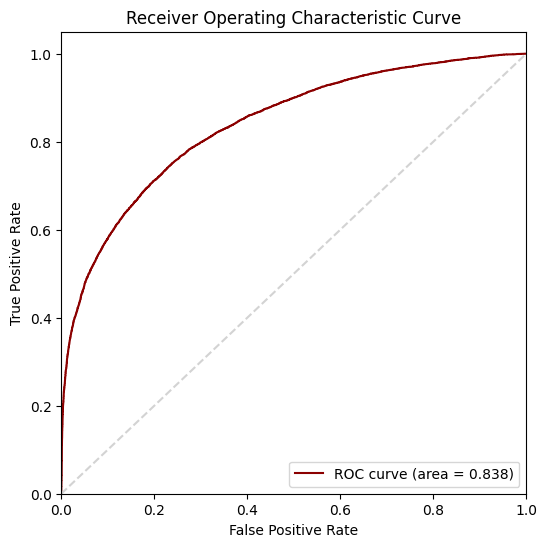

In [40]:
# --- Construct the training and testing sets ---
residual_g, train_samples, train_labels, test_samples, test_labels = generate_samples(graph=G, train_set_ratio=0.8)

# --- Create feature vector for all edges in training set and test set ---
train_features = feature_extractor(G, train_samples)
test_features = feature_extractor(G, test_samples)

fpr_1, tpr_1, roc_auc_1 = get_roc_log(G, train_features, test_features, train_labels, test_labels)

In [51]:
model = gensim.models.Word2Vec.load('/content/drive/MyDrive/mlns/models/deepwalk_0.model')
fpr_2, tpr_2, roc_auc_2 = get_roc_emb(model.wv, train_samples, test_samples, train_labels, test_labels, plot_roc=False)

100%|██████████| 35292/35292 [00:00<00:00, 206329.58it/s]


In [52]:
model = gensim.models.Word2Vec.load('/content/drive/MyDrive/mlns/models/nodel2vec_5.model')
fpr_3, tpr_3, roc_auc_3 = get_roc_emb(model.wv, train_samples, test_samples, train_labels, test_labels, plot_roc=False)

100%|██████████| 35292/35292 [00:00<00:00, 214846.82it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


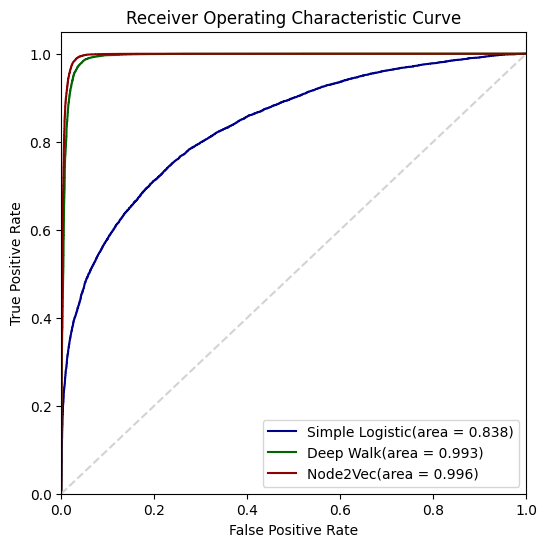

In [54]:
plt.figure(figsize=(6,6))
plt.plot(fpr_1, tpr_1, color='darkblue', label='Simple Logistic(area = %0.3f)' % roc_auc_1)
plt.plot(fpr_2, tpr_2, color='darkgreen', label='Deep Walk(area = %0.3f)' % roc_auc_2)
plt.plot(fpr_3, tpr_3, color='darkred', label='Node2Vec(area = %0.3f)' % roc_auc_3)
plt.plot([0, 1], [0, 1], color='lightgray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()